In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import random
from sklearn.utils import shuffle
from skimage.feature import hog
from skimage import exposure
from tqdm import tqdm
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

In [7]:
# Membaca  kedua dataset
train_df = pd.read_csv('emnist-letters-train.csv', header=None)
test_df = pd.read_csv('emnist-letters-test.csv', header=None)

In [8]:
# Gabungkan dataset
full_df = pd.concat([train_df, test_df], ignore_index=True)
full_df.columns = ['label'] + [f'pixel{i}' for i in range(784)]

In [9]:
# Ambil 100 data dari tiap kelas (1-26) → total 2600
balanced_df = pd.DataFrame()

for label in range(1, 27):  # 1=A, ..., 26=Z
    samples = full_df[full_df['label'] == label].sample(n=100, random_state=42)
    balanced_df = pd.concat([balanced_df, samples])

In [10]:
# Shuffle
balanced_df = shuffle(balanced_df, random_state=42).reset_index(drop=True)

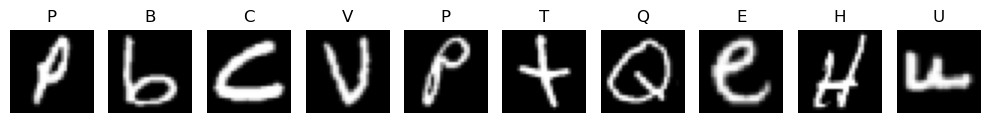

In [11]:
# Visualisasi contoh data
def plot_samples(df, num_samples=10):
    plt.figure(figsize=(10, 2))
    for i in range(num_samples):
        image = df.iloc[i, 1:].values.reshape(28, 28).T  # Transpose karena format EMNIST
        label = df.iloc[i, 0]
        plt.subplot(1, num_samples, i+1)
        plt.imshow(image, cmap='gray')
        plt.title(chr(label + 64))  # label 1 → 'A', 2 → 'B', ...
        plt.axis('off')
    plt.tight_layout()
    plt.show()

plot_samples(balanced_df)

In [12]:
# Split 80% train, 20% test
n_total = len(balanced_df)
n_train = int(0.8 * n_total)

train_final = balanced_df.iloc[:n_train]
test_final = balanced_df.iloc[n_train:]


In [13]:
# Simpan kembali
train_final.to_csv('emnist-letters-train-balanced.csv', index=False, header=False)
test_final.to_csv('emnist-letters-test-balanced.csv', index=False, header=False)

print("Dataset balanced dan disimpan:")
print(f"Train: {train_final.shape[0]} samples")
print(f"Test : {test_final.shape[0]} samples")

Dataset balanced dan disimpan:
Train: 2080 samples
Test : 520 samples


# 2. Feature Extraction

In [14]:
# Load balanced datasets
train_df = pd.read_csv('emnist-letters-train-balanced.csv', header=None)
test_df = pd.read_csv('emnist-letters-test-balanced.csv', header=None)

In [15]:
# Pisahkan label dan data piksel
y_train = train_df.iloc[:, 0].values
X_train_raw = train_df.iloc[:, 1:].values

y_test = test_df.iloc[:, 0].values
X_test_raw = test_df.iloc[:, 1:].values

In [16]:
# Fungsi ekstraksi HOG
def extract_hog_features(images, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=False):
    features = []
    hog_images = []
    
    for img_flat in images:
        img = img_flat.reshape((28, 28)).T  # Transpose untuk format EMNIST
        if visualize:
            feat, hog_image = hog(
                img, 
                orientations=orientations,
                pixels_per_cell=pixels_per_cell,
                cells_per_block=cells_per_block,
                visualize=True
            )
            features.append(feat)
            hog_images.append(hog_image)
        else:
            feat = hog(
                img, 
                orientations=orientations,
                pixels_per_cell=pixels_per_cell,
                cells_per_block=cells_per_block,
                visualize=False
            )
            features.append(feat)
    
    return (np.array(features), hog_images) if visualize else np.array(features)

In [17]:
# parameter HOG 
hog_params = {
    "orientations": 9,
    "pixels_per_cell": (4, 4),
    "cells_per_block": (2, 2)
}

In [18]:
# Ekstrak fitur
X_train_hog = extract_hog_features(X_train_raw, **hog_params)

print("HOG feature extraction selesai")
print(f"- Train shape: {X_train_hog.shape}")

HOG feature extraction selesai
- Train shape: (2080, 1296)


In [19]:
X_test_hog = extract_hog_features(X_test_raw, **hog_params)

print("HOG feature extraction selesai")
print(f"- Test shape: {X_test_hog.shape}")

HOG feature extraction selesai
- Test shape: (520, 1296)


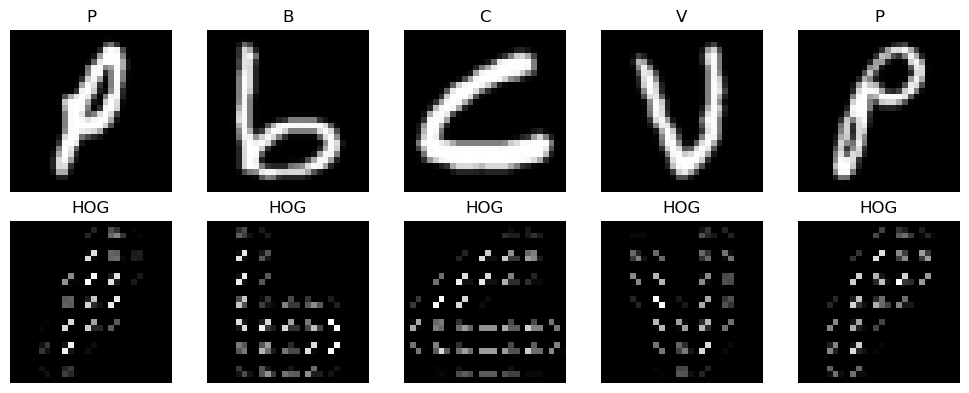

In [20]:
# Visualisasi beberapa HOG
_, hog_images = extract_hog_features(X_train_raw[:5], visualize=True, **hog_params)

plt.figure(figsize=(10, 4))
for i in range(5):
    plt.subplot(2, 5, i+1)
    plt.imshow(X_train_raw[i].reshape(28, 28).T, cmap='gray')
    plt.title(chr(y_train[i] + 64))
    plt.axis('off')
    
    plt.subplot(2, 5, i+6)
    plt.imshow(hog_images[i], cmap='gray')
    plt.title('HOG')
    plt.axis('off')

plt.tight_layout()
plt.show()

# 3. Classification

In [21]:
# Parameter untuk Grid Search
param_grid = {
    'kernel': ['linear', 'rbf',],
    'C': [1, 10],
    'gamma': ['scale', 0.01, 0.001]
}

In [22]:
# Inisialisasi model dan Grid Search
svm = SVC()
grid_search = GridSearchCV(svm, param_grid, cv=5, n_jobs=-1, verbose=1)

In [23]:
# Training dan ukur waktu
start_time = time.time()
grid_search.fit(X_train_hog, y_train)
end_time = time.time()
print(f"\n Training Time: {end_time - start_time:.2f} seconds")

Fitting 5 folds for each of 12 candidates, totalling 60 fits

 Training Time: 138.52 seconds


In [24]:
# Parameter terbaik
print("\n Best Parameters Found:")
print(grid_search.best_params_)


 Best Parameters Found:
{'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}


In [25]:
# Evaluasi pada data training dan testing
best_model = grid_search.best_estimator_
print(grid_search.best_estimator_)

SVC(C=10)


In [26]:
# Training Performance
y_train_pred = best_model.predict(X_train_hog)
train_acc = accuracy_score(y_train, y_train_pred)
print(f"\n Training Accuracy: {train_acc:.4f}")


 Training Accuracy: 1.0000


In [27]:
# Test Performance
y_test_pred = best_model.predict(X_test_hog)
test_acc = accuracy_score(y_test, y_test_pred)
print(f" Test Accuracy: {test_acc:.4f}")

 Test Accuracy: 0.8500


In [28]:
# Classification report (Test)
print("\n Classification Report (Test Set):")
print(classification_report(y_test, y_test_pred, target_names=[chr(i+64) for i in range(1, 27)]))


 Classification Report (Test Set):
              precision    recall  f1-score   support

           A       0.82      0.78      0.80        18
           B       0.89      0.84      0.86        19
           C       0.71      0.67      0.69        15
           D       0.82      0.93      0.88        15
           E       0.87      0.81      0.84        16
           F       0.93      0.78      0.85        18
           G       0.82      0.72      0.77        25
           H       0.73      0.90      0.81        21
           I       0.57      0.68      0.62        25
           J       0.94      0.94      0.94        18
           K       0.90      0.86      0.88        22
           L       0.54      0.50      0.52        26
           M       0.90      1.00      0.95        19
           N       0.80      0.80      0.80        15
           O       0.90      0.95      0.93        20
           P       0.95      0.87      0.91        23
           Q       0.83      0.74      0.78  

In [29]:
# Classification report (Train)
print("\n Classification Report (Train Set):")
print(classification_report(y_train, y_train_pred, target_names=[chr(i+64) for i in range(1, 27)]))


 Classification Report (Train Set):
              precision    recall  f1-score   support

           A       1.00      1.00      1.00        82
           B       1.00      1.00      1.00        81
           C       1.00      1.00      1.00        85
           D       1.00      1.00      1.00        85
           E       1.00      1.00      1.00        84
           F       1.00      1.00      1.00        82
           G       1.00      1.00      1.00        75
           H       1.00      1.00      1.00        79
           I       1.00      1.00      1.00        75
           J       1.00      1.00      1.00        82
           K       1.00      1.00      1.00        78
           L       1.00      1.00      1.00        74
           M       1.00      1.00      1.00        81
           N       1.00      1.00      1.00        85
           O       1.00      1.00      1.00        80
           P       1.00      1.00      1.00        77
           Q       1.00      1.00      1.00 

# 4. Evaluation

In [30]:
# Fungsi evaluasi untuk berbagai metrik
def evaluate_performance(y_true, y_pred, dataset_name="Dataset"):
    acc = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='macro', zero_division=0)
    recall = recall_score(y_true, y_pred, average='macro', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='macro', zero_division=0)

    print(f"\n Evaluation on {dataset_name}:")
    print(f"  - Accuracy : {acc:.4f}")
    print(f"  - Precision: {precision:.4f}")
    print(f"  - Recall   : {recall:.4f}")
    print(f"  - F1-score : {f1:.4f}")
    return acc, precision, recall, f1

In [31]:
# Prediksi untuk training dan testing set
y_train_pred = best_model.predict(X_train_hog)
y_test_pred = best_model.predict(X_test_hog)

In [32]:
# Evaluasi performa
evaluate_performance(y_train, y_train_pred, "Training Set (80%)")
evaluate_performance(y_test, y_test_pred, "Testing Set (20%)")


 Evaluation on Training Set (80%):
  - Accuracy : 1.0000
  - Precision: 1.0000
  - Recall   : 1.0000
  - F1-score : 1.0000

 Evaluation on Testing Set (20%):
  - Accuracy : 0.8500
  - Precision: 0.8582
  - Recall   : 0.8568
  - F1-score : 0.8555


(0.85, 0.8582256544360617, 0.8568152891763069, 0.855533661099988)

In [33]:
# Buat confusion matrix
cm = confusion_matrix(y_test, y_test_pred)

In [34]:
# Label kelas (EMNIST Letters: 1 = 'A', 2 = 'B', ..., 26 = 'Z')
labels = [chr(i) for i in range(65, 91)]  # A-Z

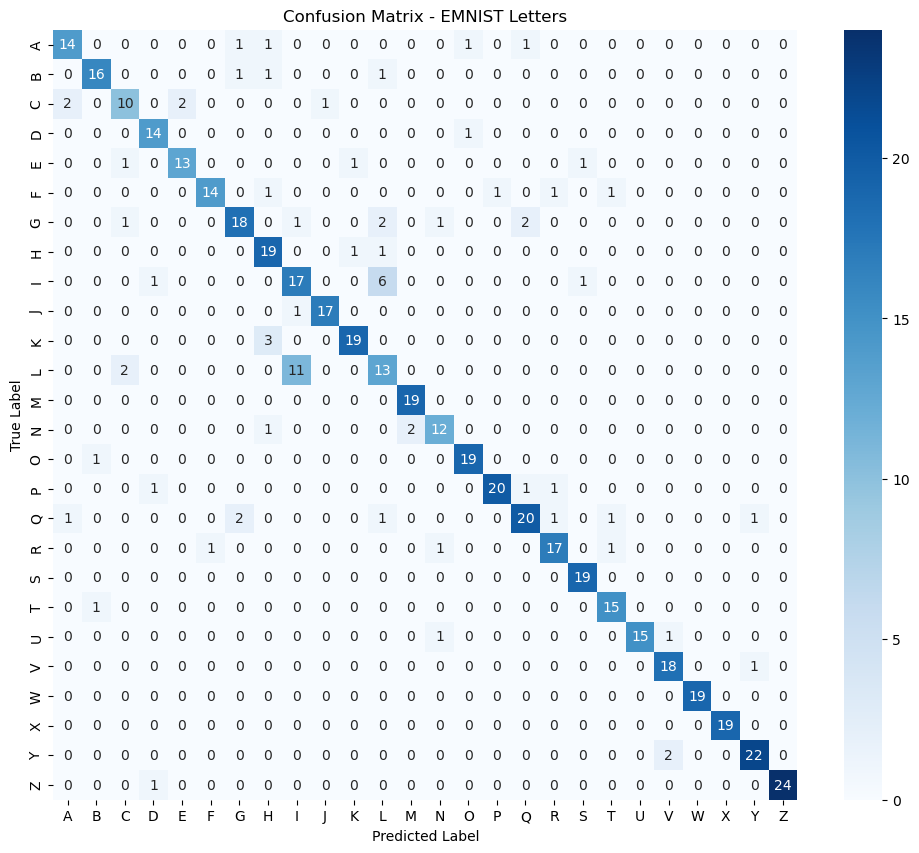

In [35]:
# Tampilan confusion matrix dengan seaborn heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix - EMNIST Letters")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

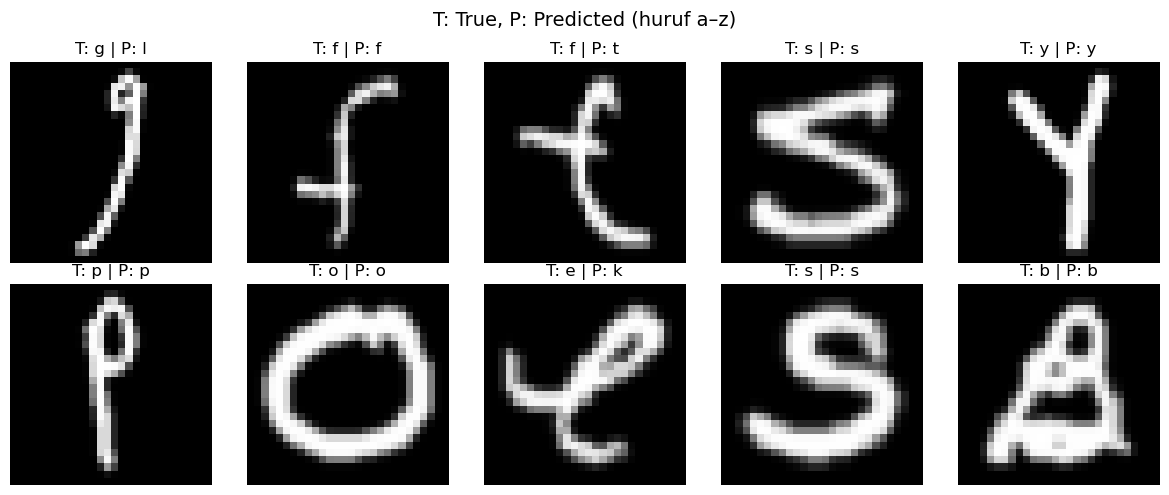

In [129]:
# Pilih 10 indeks acak dari data uji
indices = random.sample(range(len(X_test_raw)), 10)

# Buat figure
plt.figure(figsize=(12, 5))

for i, idx in enumerate(indices):
    img = X_test_raw[idx].reshape(28, 28).T  # Transpose agar orientasi sesuai
    true_label = y_test[idx]
    pred_label = y_test_pred[idx]

    plt.subplot(2, 5, i + 1)
    plt.imshow(img, cmap='gray')
    plt.title(f"T: {chr(true_label + 96)} | P: {chr(pred_label + 96)}")  # chr(97) = 'a'
    plt.axis('off')

plt.suptitle("T: True, P: Predicted (huruf a–z)", fontsize=14)
plt.tight_layout()
plt.show()